In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scanpy as sc
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import torch
import scipy.sparse as sp
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

plt.rcParams['font.size'] = 12

# Load data

## sc data can download from https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-HPF-raw.h5ad

In [2]:
sc_data = sc.read('../datas/mouse_brain_stereo_seq/WMB_10Xv3_hippocampus_scrna.h5ad')

meta = pd.read_csv('../datas/mouse_brain_stereo_seq/scrna_cell_metadata.csv', index_col=0)

sc_data = sc_data[sc_data.obs_names.isin(meta.index), ].copy()

sc_data.obs = meta.loc[sc_data.obs_names, ]

cluster_info = pd.read_excel('../datas/mouse_brain_stereo_seq/scrna_cl.df_CCN202307220.xlsx')
cluster_info = cluster_info.loc[cluster_info.cl.isin(sc_data.obs.cluster_alias.tolist()), ]

sc_data

AnnData object with n_obs × n_vars = 181055 × 32285
    obs: 'cell_barcode', 'barcoded_cell_sample_label', 'library_label', 'feature_matrix_label', 'entity', 'brain_section_label', 'library_method', 'region_of_interest_acronym', 'donor_label', 'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y', 'cluster_alias', 'abc_sample_id'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'

In [3]:
sc_data.obs['cell_type'] = sc_data.obs['cluster_alias']
sc_data.obs['cell_type'] = sc_data.obs['cell_type'].replace(dict(zip(cluster_info.cl.tolist(), 
                                                                     cluster_info.subclass_label.tolist())))

In [4]:
sp_data = sc.read('../datas/mouse_brain_stereo_seq/mouse_hippocampus_region/SS200000128TR_E2_stereo_seq_hippocampus_spatial.h5ad')
sp_data

AnnData object with n_obs × n_vars = 5451 × 24233
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'right_hemisphere', 'region', 'broad_region', 'slice'
    obsm: 'spatial'

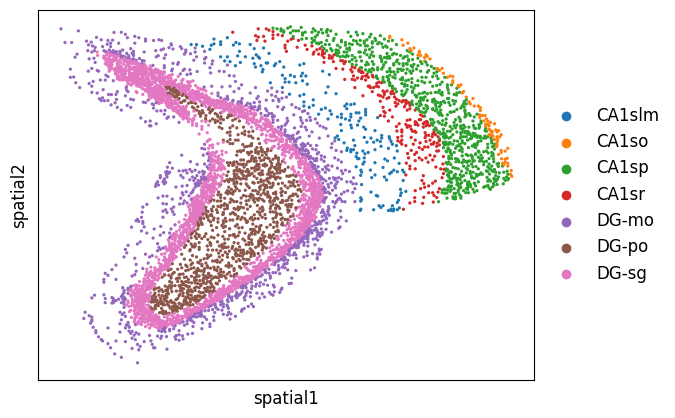

In [5]:
sc.pl.embedding(sp_data, basis='spatial', color='region', title='')

# Process data

In [6]:
sc_data.var.set_index('gene_symbol', inplace=True)

sc_data.var_names = sc_data.var_names.astype(str)

In [7]:
sc_data.var_names_make_unique()
sp_data.var_names_make_unique()

In [8]:
# Convert to row-sparse matrix
if not sp.issparse(sc_data.X):
    sc_data.X = sp.csr_matrix(sc_data.X)
    
if not sp.issparse(sp_data.X):
    temp = sp.csr_matrix(np.array(sp_data.X)).copy()
    del sp_data.X
    sp_data.X = temp.copy()
    del temp

In [9]:
sc_data.X = sc_data.X.astype(np.float32)
sp_data.X = sp_data.X.astype(np.float32)

In [10]:
# Please make sure cell_type is included in scRNA_data.obs
assert 'cell_type' in sc_data.obs

In [11]:
# Filter rare cell types: cell types with fewer than 100 cells
cell_type_counts = sc_data.obs['cell_type'].value_counts()
valid_cell_types = cell_type_counts[cell_type_counts >= 100].index
sc_data = sc_data[sc_data.obs['cell_type'].isin(valid_cell_types)].copy()

# Output results
print(f"Number of cell types in the original dataset: {cell_type_counts.shape[0]}")
print(f"Number of cell types after filtering: {len(sc_data.obs['cell_type'].unique())}")

Number of cell types in the original dataset: 78
Number of cell types after filtering: 47


In [12]:
cell_type_mapping = {

    "Astro-TE NN": "Astro",
    "Oligo NN": "Oligo",
    "Microglia NN": "Microglia",
    "OPC NN": "OPC",
    "Endo NN": "Endothelial",
    "Peri NN": "Pericyte",
    "VLMC NN": "VLMC",
    "ABC NN": "Astrocyte-Bergmann Glia",

    "CA1-ProS Glut": "CA1",
    "DG Glut": "DG",
    "CA3 Glut": "CA3",
    "SUB-ProS Glut": "Subiculum",
    "CT SUB Glut": "Cortico-Subicular",
    "HPF CR Glut": "Hippocampal CR",
    "L2/3 IT PPP Glut": "Layer 2/3",
    "L6b/CT ENT Glut": "Layer 6",
    "L2/3 IT ENT Glut": "Layer 2/3",
    "L2/3 IT PIR-ENTl Glut": "Layer 2/3",
    "ENTmv-PA-CoA Glut": "Entorhinal-PA-CoA",
    "L5 PPP Glut": "Layer 5",
    "L6 IT CTX Glut": "Layer 6",
    "L2/3 IT CTX Glut": "Layer 2/3",
    "L4/5 IT CTX Glut": "Layer 4/5",

    "Vip Gaba": "VIP",
    "Sst Gaba": "SST",
    "Lamp5 Lhx6 Gaba": "Lamp5",
    "Lamp5 Gaba": "Lamp5",
    "Pvalb Gaba": "PV",
    "Pvalb chandelier Gaba": "PV",
    "Sncg Gaba": "SNCG",

    "SMC NN": "Smooth Muscle",
    "BAM NN": "BAM",
    "RHP-CoA Ndnf Gaba": "RHP-CoA",
    "L2 IT RSP Glut": "Layer 2",
    "L2 IT EP-CLA Glut": "Layer 2",
    "OB-STR-CTX Inh IMM": "OB-STR-CTX",
    "CA2-PC-IG Glut": "CA2",
    "CHOR NN": "Choroid Plexus Cell",
    
    "L2 IT PPP-APr Glut": "Layer 2",
    "L5/6 IT TPE-ENT Glut": "Layer 5/6",
    "ENTmv-PA-CoAp Glut": "Entorhinal-PA-CoAp",
    "L2/3 IT RSP Glut": "Layer 2/3",
    "IT EP-CLA Glut": "Entorhinal-Piriform",
    "L6-CT CTX Glut": "Layer 6",
    "NP SUB Glut": "Subicular",
    "NP PPP Glut": "NP",
    "L2 IT ENT-po Glut": "Layer 2",
    "CA2-PC-IG Glut": "CA2",

    "RHP-CoA Ndnf Gaba": "RHP-CoA",

    "DG-PIR Ex IMM": "DG",

    "L6b CTX Glut": "Layer 6",
    "Astro-MT NN": "Astro",
    
    "L6 CT CTX Glut": "Layer 6",
    "CA2-FC-IG Glut": "CA2",

    "RHP-COA Ndnf Gaba": "RHP-CoA",

    "OB-STR-CTX Inh IMN": "Olfactory Bulb-Striatum-Corte",

    "Astro-NT NN": "Astro",
    
    "ENTmv-PA-COAp Glut": "ENTmv-PA-COAp",
}

sc_data.obs['cell_type'] = sc_data.obs['cell_type'].replace(cell_type_mapping)

# Run code

In [13]:
import sys
sys.path.append('../')

import SpCAST
from SpCAST.utils import preprocess_datasets

In [14]:
scRNA_data = sc_data.copy()
spRNA_data = sp_data.copy()

In [15]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

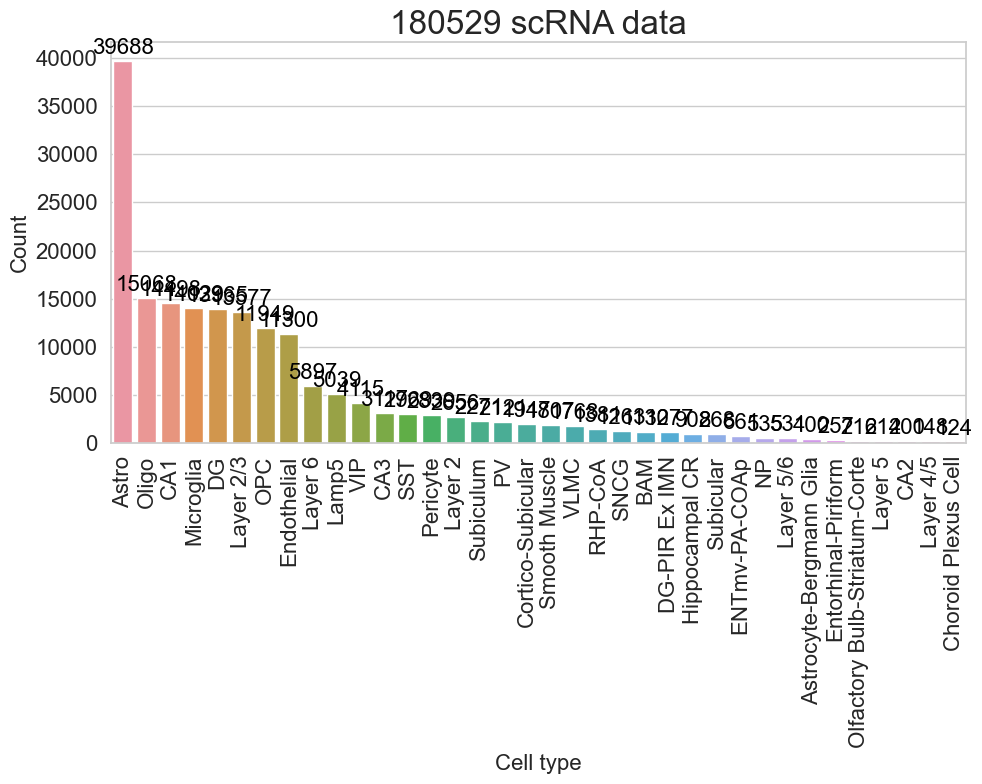

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Calculate the count for each category
sc_category_counts = scRNA_data.obs['cell_type'].value_counts().reset_index()
sc_category_counts.columns = ['Category', 'Count']

plt.figure(figsize=(10, 8))

# Draw barplot
ax = sns.barplot(x='Category', y='Count', data=sc_category_counts)

# Add title and labels
plt.title(f'{len(scRNA_data.obs)} scRNA data', fontsize=24)
plt.xlabel('Cell type', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=16)

# Increase font size for y-axis ticks
plt.yticks(fontsize=16)

# Add count labels on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=16, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [17]:
datatype = 'Seq'
# datatype = 'FISH'
assert datatype in ['FISH', 'Seq']
scRNA_data, spRNA_data = preprocess_datasets(scRNA_data, spRNA_data, 
                                             hvg_num=50000, final_n_top_genes=2000, 
                                             min_genes_in_cells=3, datatype=datatype, include_markers=True)

Preprocessing scRNA-seq data ...
scRNA Data before filtering: 180529 cells  ||  scRNA Data after filtering: 180529 cells
Normalizing and log1p raw scRNA counts...
sc data nonzero expression ratio: 17.59%
-----------------------------------------------
Preprocessing spRNA-seq data ...
Normalizing and log1p raw spRNA counts...
-----------------------------------------------
Enhance spRNA Data expression ...


100%|███████████████████████████████████████████████████████████████████████████| 5451/5451 [00:00<00:00, 38386.82it/s]
Enhance gene expression data using spatial coordinates: 100%|████████████████████| 5451/5451 [00:02<00:00, 2266.40it/s]


sp data original nonzero expression ratio: 3.64%    sp data enhanced nonzero expression ratio: 9.79%
Concatenating datasets...
We have 15215 shared genes on scRNA and spatial RNA data
Computing scRNA data marker genes ...
We ultimately use 2417 genes for training ...
Preprocessing completed...


In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

save_model_path='../model'
save_model_name='model_params.pth'

prob_df = SpCAST.train_SpCAST(scRNA_data=scRNA_data, spRNA_data=spRNA_data,
                              latent_dim1=30, latent_dim2=20, 
                              batch_size=256, loss_step=1, n_epochs=10, device=device, 
                              save_model_path=save_model_path, save_model_name=save_model_name)

Size of scRNA-seq data Input:  (180529, 2417)
Size of spRNA-seq data Input:  (5451, 2417)
Class distribution: [39688   400  1132 14498   200  3117   124  1947 13965  1077   661 11300
   257   902  5039  2656 13577   148   214   531  5897 14029   535 11949
   216 15068  2121  2839  1381  1263  2969  1807   868  2271  4115  1768]
Class weights: [0.01892601 0.03343436 0.02849637 0.02091502 0.03778856 0.02491057
 0.04150605 0.02645755 0.02099709 0.02869944 0.0308539  0.02147346
 0.03608963 0.02944643 0.02350739 0.02541604 0.02105926 0.04004924
 0.03731479 0.03192857 0.02308175 0.02098704 0.03189051 0.02134575
 0.03725057 0.02083119 0.02616204 0.02520314 0.0277135  0.02805982
 0.02506207 0.02672065 0.02961343 0.02593083 0.02407942 0.02679857]
Train the model..........


Training:  10%|███████▎                                                                 | 1/10 [00:01<00:10,  1.21s/it]

Epoch:1 MMD Loss:6.143  Class Loss:45.366  Recon loss: 1637.134  Train_Accuracy: 53.23% 


Training:  20%|██████████████▌                                                          | 2/10 [00:01<00:06,  1.26it/s]

Epoch:2 MMD Loss:5.419  Class Loss:16.128  Recon loss: 2308.930  Train_Accuracy: 84.89% 


Training:  30%|█████████████████████▉                                                   | 3/10 [00:02<00:04,  1.51it/s]

Epoch:3 MMD Loss:4.900  Class Loss:8.939  Recon loss: 1993.887  Train_Accuracy: 91.07% 


Training:  40%|█████████████████████████████▏                                           | 4/10 [00:02<00:03,  1.66it/s]

Epoch:4 MMD Loss:4.666  Class Loss:5.613  Recon loss: 1523.141  Train_Accuracy: 94.39% 


Training:  50%|████████████████████████████████████▌                                    | 5/10 [00:03<00:02,  1.75it/s]

Epoch:5 MMD Loss:4.423  Class Loss:4.103  Recon loss: 1191.727  Train_Accuracy: 96.00% 


Training:  60%|███████████████████████████████████████████▊                             | 6/10 [00:03<00:02,  1.82it/s]

Epoch:6 MMD Loss:4.269  Class Loss:3.034  Recon loss: 980.387  Train_Accuracy: 97.27% 


Training:  70%|███████████████████████████████████████████████████                      | 7/10 [00:04<00:01,  1.86it/s]

Epoch:7 MMD Loss:4.084  Class Loss:2.473  Recon loss: 849.741  Train_Accuracy: 97.57% 


Training:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [00:04<00:01,  1.88it/s]

Epoch:8 MMD Loss:3.954  Class Loss:1.846  Recon loss: 756.735  Train_Accuracy: 98.53% 


Training:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [00:05<00:00,  1.91it/s]

Epoch:9 MMD Loss:3.858  Class Loss:1.659  Recon loss: 692.815  Train_Accuracy: 98.30% 


Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]

Epoch:10 MMD Loss:3.688  Class Loss:1.319  Recon loss: 648.028  Train_Accuracy: 98.93% 


Testing the model..........


Testing scRNA data: 100%|███████████████████████████████████████████████████████████| 706/706 [00:04<00:00, 159.75it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

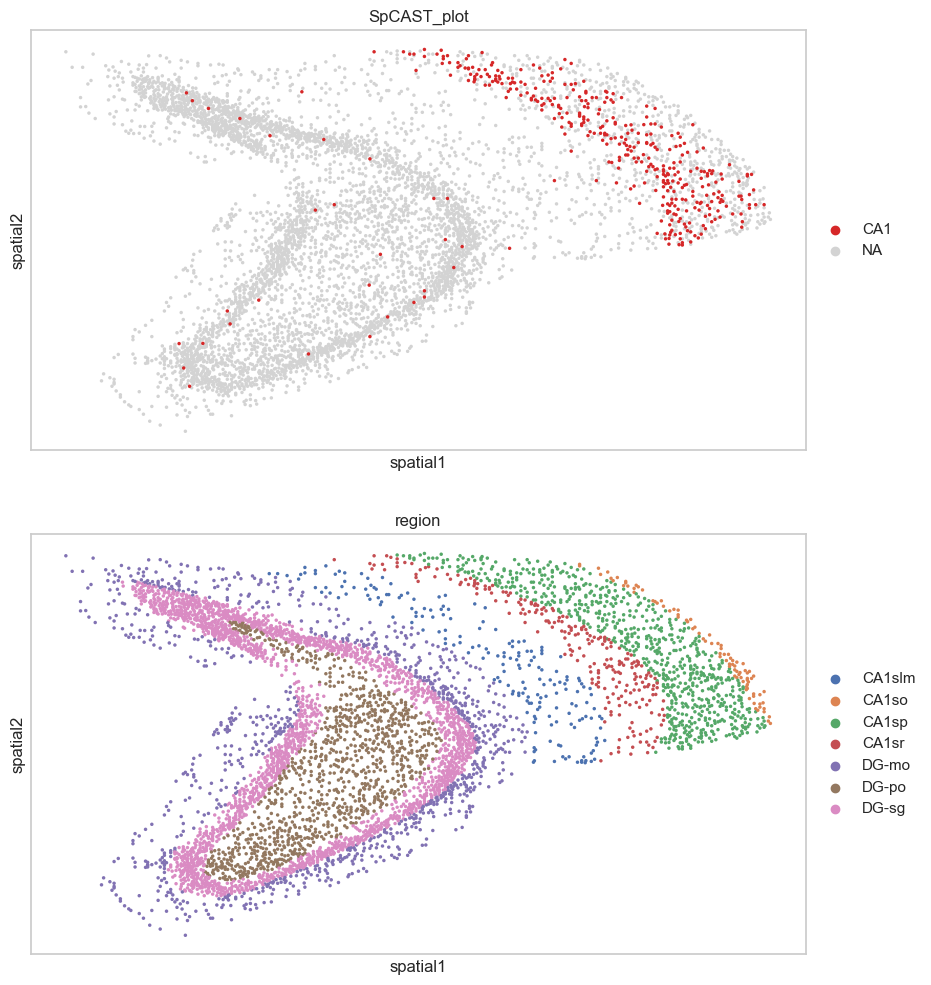

 33%|████████████████████████████                                                        | 1/3 [00:00<00:00,  2.20it/s]

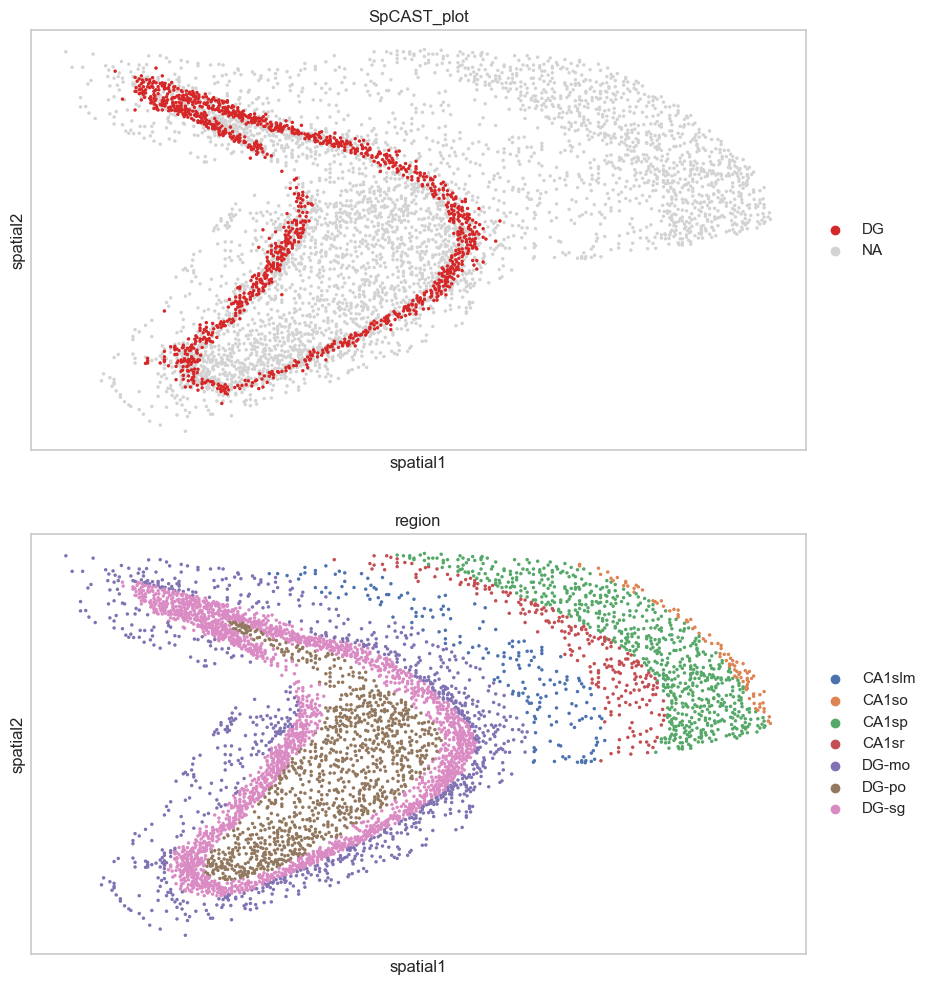

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:00<00:00,  2.24it/s]

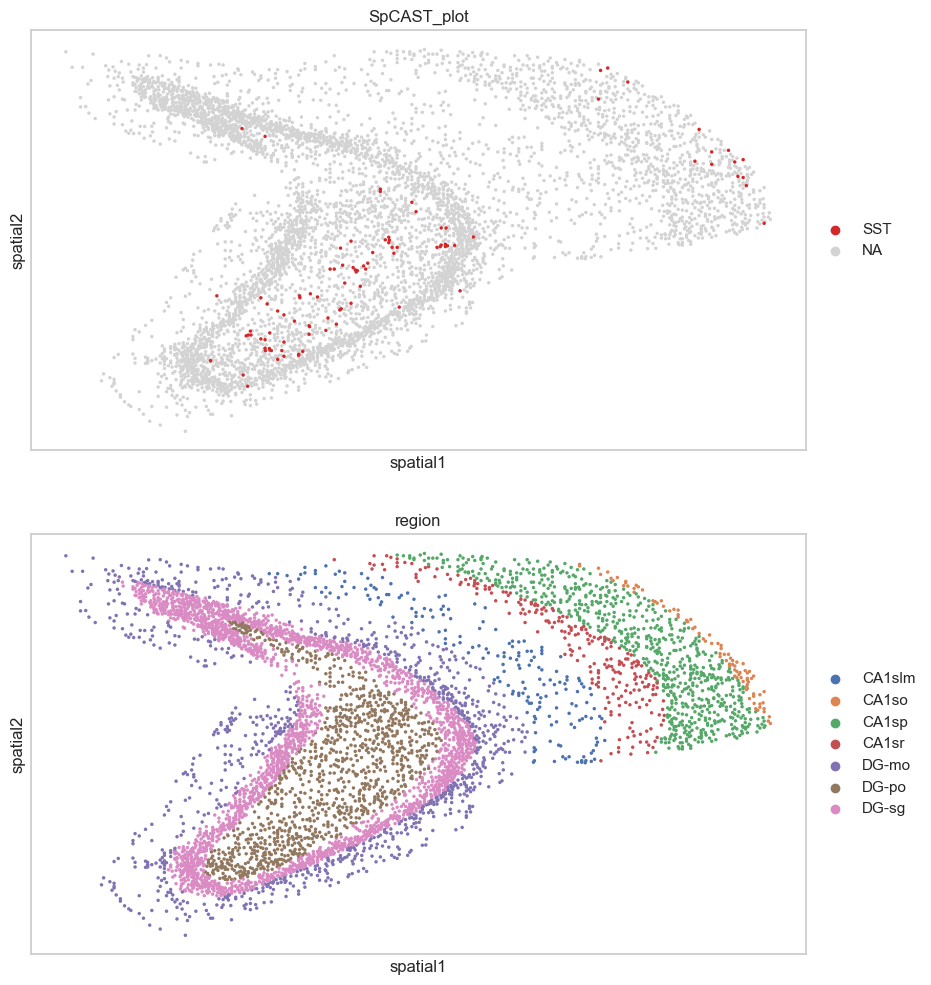

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


In [19]:
plot_layers = [
    'CA1',
    'DG',
    'SST'
]

for plot_layer in tqdm(plot_layers):

    fig, axes = plt.subplots(2, 1, figsize=(10, 6*2))  

    spRNA_data.obs['SpCAST_plot'] = spRNA_data.obs['SpCAST_predicted'].astype(str)
    spRNA_data.obs.loc[~spRNA_data.obs['SpCAST_plot'].isin([plot_layer]), 'SpCAST_plot'] = np.NAN
    

    sc.pl.embedding(spRNA_data, basis='spatial', color=['SpCAST_plot'], ax=axes[0], palette=["#d62728"], size=25, show=False) 

    sc.pl.embedding(spRNA_data, basis='spatial', color=['region'], ax=axes[1], size=25, show=False) 
    
    plt.show(fig)  

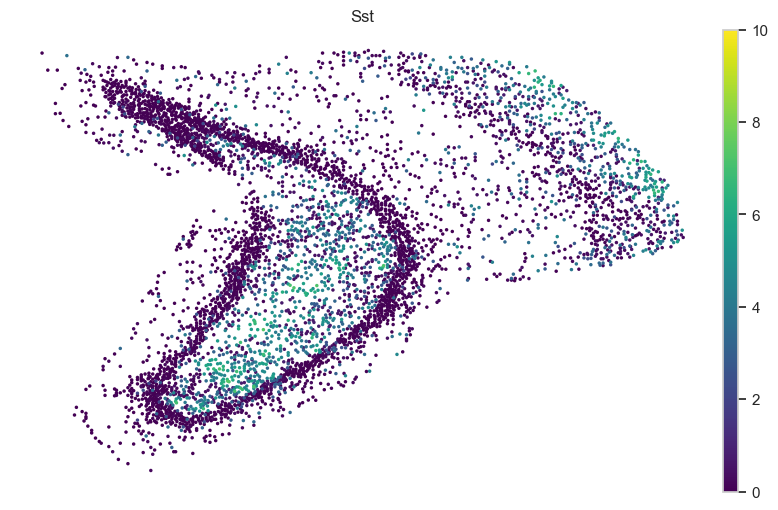

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sc.pl.embedding(spRNA_data, basis='spatial', color=['Sst'], ax=axes, vmax=10, size=25, cmap='viridis', frameon=False)